Nama : Arif Muhammad Laduni

NIM : 1103213003

Dataset : MNIST FASHION

# Import Library

In [2]:
# Memastikan TensorFlow sudah diinstall
!pip install tensorflow

# Mengimport library yang dibutuhkan
import time
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras import backend as K
import tensorflow as tf

# Memuat Dataset

In [3]:
# Check the current image data format
image_data_format = K.image_data_format()
print(image_data_format)  # Output will be either 'channels_last' or 'channels_first'

channels_last


In [4]:
import tensorflow_datasets as tfds

# Train
train_fasion_mnist = tfds.as_numpy(tfds.load("fashion_mnist", split="train", batch_size=-1))
X_train, y_train   = train_fasion_mnist["image"], train_fasion_mnist["label"]

# Test
test_fasion_mnist  = tfds.as_numpy(tfds.load("fashion_mnist", split="test", batch_size=-1))
X_test, y_test     = test_fasion_mnist["image"], test_fasion_mnist["label"]

print("Train Samples:", len(X_train))
print("Test Samples:",  len(X_test))

Train Samples: 60000
Test Samples: 10000



# Parameter

In [5]:
#######################
# Dimension of images #
#######################
img_width  = 28
img_height = 28
channels   = 1

######################
# Parms for learning #
######################
batch_size = 250
num_epochs = 80
iterations = 5          # number of iterations
nb_augmentation = 2     # defines the number of additional augmentations of one image

####################
#       Data       #
####################
clothes = {0: 'T-shirt/top',
           1: 'Trouser',
           2: 'Pullover',
           3: 'Dress',
           4: 'Coat',
           5: 'Sandal',
           6: 'Shirt',
           7: 'Sneaker',
           8: 'Bag',
           9: 'Ankle boot'}

mnist_classes       = [i for i in range(10)]
num_classes         = 10

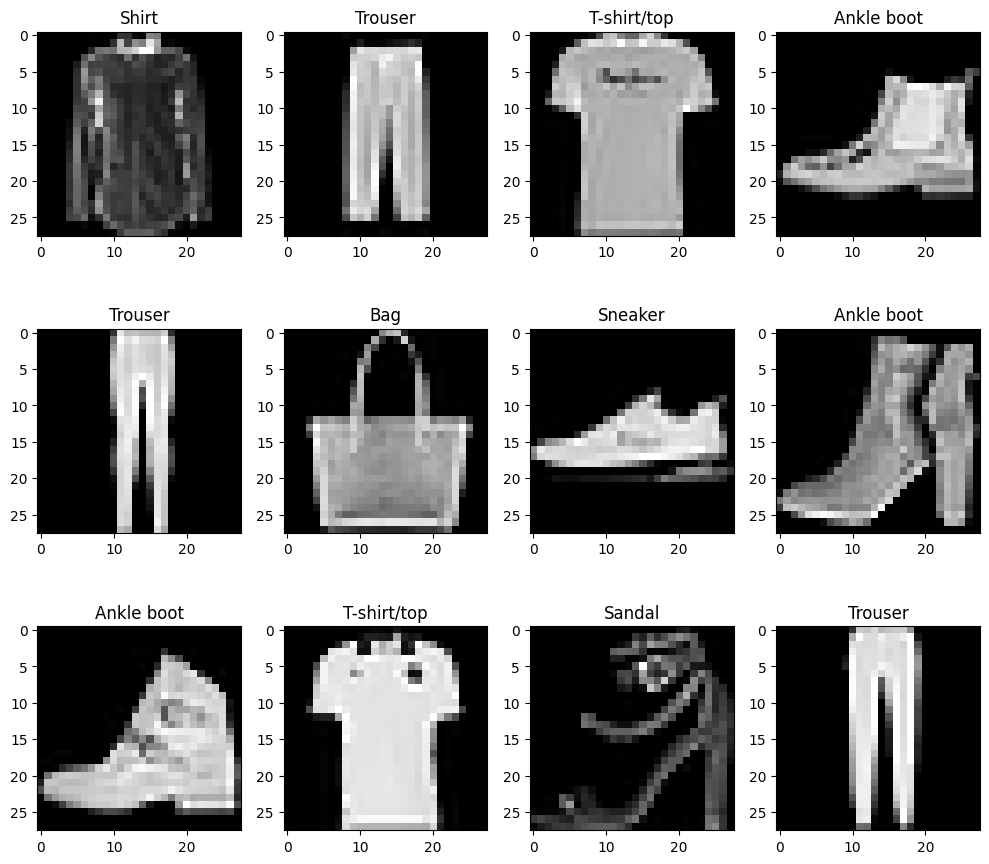

In [6]:
fig, axes = plt.subplots(3, 4,figsize=(10,10))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = X_train[index].reshape((28, 28))
        obj = y_train[index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothes[obj])
        plt.tight_layout()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defines the options for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest'
)

def image_augmentation(image, nb_of_augmentation):
    images = []
    image = image.reshape(1, img_height, img_width, channels)
    i = 0
    for x_batch in datagen.flow(image, batch_size=1):
        images.append(x_batch)
        i += 1
        if i >= nb_of_augmentation:
            # interrupt augmentation
            break
    return images

# Preprocessing Data

In [8]:
import tensorflow as tf

def preprocess_data(images, targets, use_augmentation=False, nb_of_augmentation=1):

    X = []
    y = []
    for x_, y_ in zip(images, targets):

        # scaling pixels between 0.0-1.0
        x_ = x_ / 255.

        # data Augmentation
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(img_height, img_width, channels))
                y.append(y_)

        X.append(x_)
        y.append(y_)
    print('*Preprocessing completed: %i samples\n' % len(X))
    return np.array(X), tf.keras.utils.to_categorical(y)

In [9]:
X_train_shaped, y_train_shaped = preprocess_data(
    X_train, y_train,
    use_augmentation=True,
    nb_of_augmentation=nb_augmentation
)

X_test_shaped, y_test_shaped   = preprocess_data(X_test,  y_test)

*Preprocessing completed: 180000 samples

*Preprocessing completed: 10000 samples



# Model Architecture

In [10]:
def create_model():
    """
    Creates a simple sequential model
    """

    cnn = tf.keras.Sequential()

    cnn.add(tf.keras.layers.InputLayer(input_shape=(img_height,img_width,channels)))

    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())

    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.1))

    # Conv + Maxpooling
    cnn.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn.add(tf.keras.layers.Flatten())

    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(256, activation='relu'))

    # Dropout
    cnn.add(tf.keras.layers.Dropout(0.5))

    # Fully Connected Layer
    cnn.add(tf.keras.layers.Dense(64, activation='relu'))

    # Normalization
    cnn.add(tf.keras.layers.BatchNormalization())

    cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    cnn.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics=['accuracy'])

    return cnn

create_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 28, 28, 1)         4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        1088      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        65600     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0

# Pelatihan Model

In [13]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=5,verbose=True)

cnn = create_model()
history = cnn.fit(X_train_shaped, y_train_shaped,batch_size=batch_size,epochs=15,
                    validation_data=(X_test_shaped, y_test_shaped),callbacks=[early_stop])


Epoch 1/15
720/720 [==============================] - 516s 714ms/step - loss: 0.5059 - accuracy: 0.8179 - val_loss: 0.3157 - val_accuracy: 0.8849
Epoch 2/15
720/720 [==============================] - 504s 699ms/step - loss: 0.3301 - accuracy: 0.8788 - val_loss: 0.2740 - val_accuracy: 0.9001
Epoch 3/15
720/720 [==============================] - 506s 703ms/step - loss: 0.2902 - accuracy: 0.8933 - val_loss: 0.2497 - val_accuracy: 0.9063
Epoch 4/15
720/720 [==============================] - 499s 694ms/step - loss: 0.2673 - accuracy: 0.9008 - val_loss: 0.2510 - val_accuracy: 0.9009
Epoch 5/15
720/720 [==============================] - 503s 698ms/step - loss: 0.2517 - accuracy: 0.9066 - val_loss: 0.2279 - val_accuracy: 0.9167
Epoch 6/15
720/720 [==============================] - 503s 698ms/step - loss: 0.2374 - accuracy: 0.9121 - val_loss: 0.2297 - val_accuracy: 0.9161
Epoch 7/15
720/720 [==============================] - 503s 698ms/step - loss: 0.2279 - accuracy: 0.9158 - val_loss: 0.2128 -

# Evaluasi Model

In [24]:
# Evaluasi model dengan data test
test_loss, test_acc = cnn.evaluate(X_test_shaped, y_test_shaped, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

313/313 - 7s - loss: 0.2090 - accuracy: 0.9263 - 7s/epoch - 23ms/step

Test accuracy: 0.9263


# Visualisasi Akurasi

In [25]:
RUN = 0 # you can choose one of the different models trained above
model = create_model()
model.load_weights("fashion_mnist-%i.hdf5" % RUN)

In [35]:
def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Accuracy
    ax1.set_title('Model accuracy - %s' % title)
    ax1.plot(history.history['accuracy']) # Access metrics using .history attribute
    ax1.plot(history.history['val_accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # Loss
    ax2.set_title('Model loss - %s' % title)
    ax2.plot(history.history['loss']) # Access metrics using .history attribute
    ax2.plot(history.history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc='upper left')

    fig.set_size_inches(20, 5)
    plt.show()

In [31]:
histories = [history]

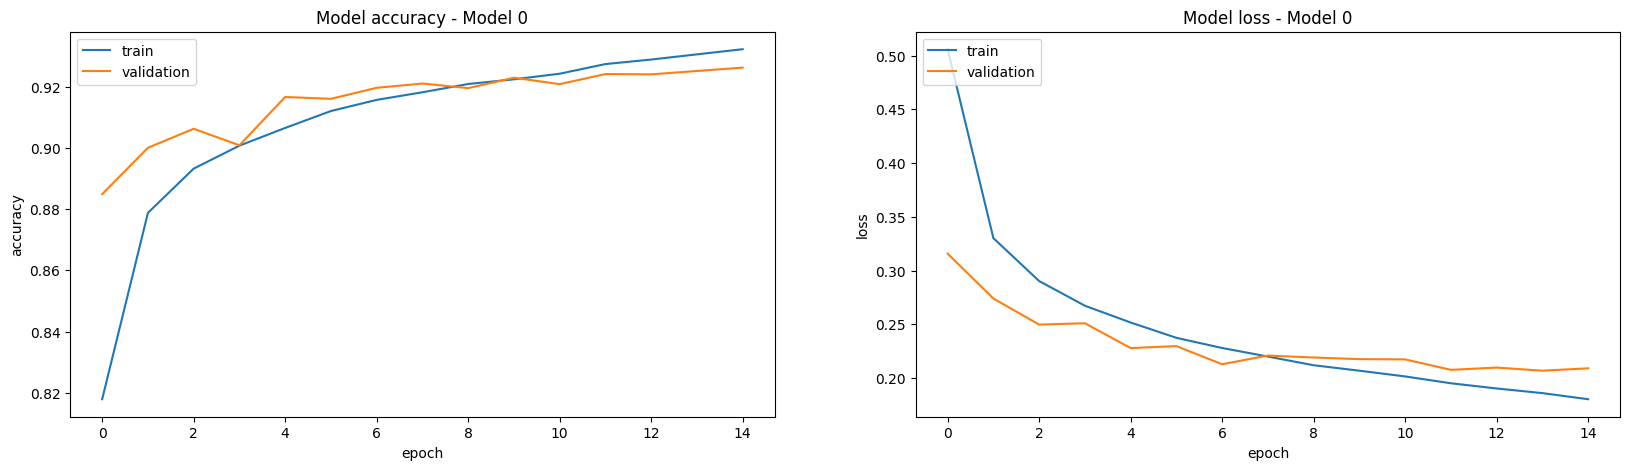

In [36]:
plot_train_val('Model %i' % RUN, histories[RUN])

# Visualisasi Prediksi

In [37]:
def plot_sample_predictions(classes, model, X_test, y_test):
    """
    This function displays images randomly and tries to predict the correct class
    """

    class_ = 0
    images_per_row = 5
    rows = len(classes) // images_per_row

    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)

        for i, axis in enumerate(axis):

            elements = np.squeeze(np.argwhere(y_test==class_))
            random   = np.random.randint(len(elements))

            X = X_test[elements[random]]
            y = y_test[elements[random]]

            fig.set_size_inches(10, 20)

            x_reshape = X.reshape([1,img_height,img_width,channels])
            axis.text(0,32,'Predicted: {}'.format(classes[np.argmax(model.predict(x_reshape))]))
            axis.text(0,36,'Correct: {}'.format((classes)[y]))
            axis.imshow(np.squeeze(X), cmap='gray')
            axis.axis('off')
            class_ +=1
    plt.show()

1/1 [==============================] - 0s 21ms/step


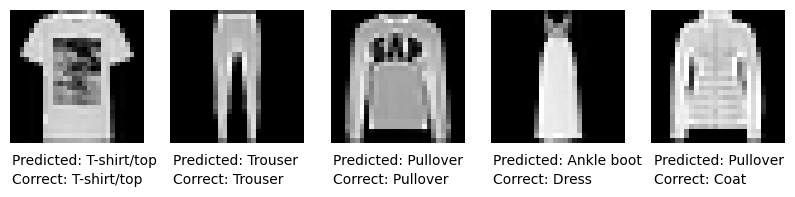

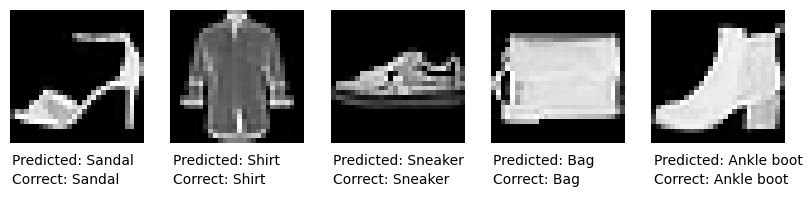

In [40]:

plot_sample_predictions(list(clothes.values()), model, X_test, y_test)